# Decision Tree Regression

In [16]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import uuid
import copy

from abc import ABCMeta, abstractmethod

sns.set()
%matplotlib inline

In [2]:
data_train = np.loadtxt('krr-train.txt')

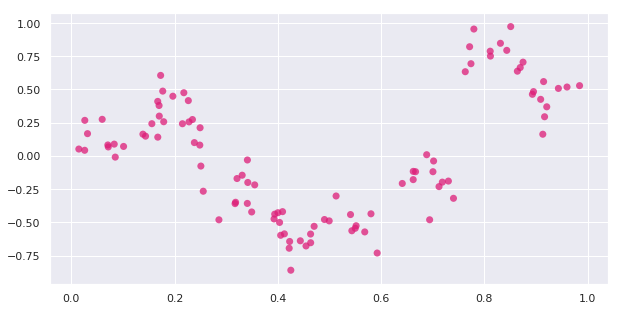

In [37]:
fig = plt.figure(figsize=(10, 5))
axis = plt.axes()
axis.scatter(data_train[:, 0], data_train[:, 1], 
             s=50, color='#dd1c77', alpha=0.75, edgecolors='none')
plt.show()

In [4]:
def mean_sq_error(target, predictd):
    #assert len(target) == len(predictd)
    #assert len(target.shape) == 1
    #assert len(predictd.shape) == 1
    return np.mean(np.square(target - predictd))

def predict_note_value(values):
    assert len(values.shape) == 1
    return np.mean(values)

In [5]:
x = np.array([2, 2, 3])
y = np.array([1, 1, 2])
assert mean_sq_error(x, y) == 1

In [6]:
class Node(object):
    def __init__(self, node_id=None, description=None):
        self.id = node_id
        self.description = description

    def set_id(self, id):
        self.id = id

    def get_id(self):
        return str(self.id)

    def set_description(self, description):
        self.description = description

    def get_description(self):
        return self.description


class Leaf(Node):
    def __init__(self, values, node_id=None, description=None):
        Node.__init__(self, node_id, description)
        self.values = values

    def get_values(self):
        return self.values


class Internal(Node):
    def __init__(self, dim, threshold, left_child, right_child, node_id=None, description=None):
        Node.__init__(self, node_id, description)
        self.dim = dim
        self.threshold = threshold
        self.left_child = left_child
        self.right_child = right_child

In [7]:
class BaseTree(metaclass=ABCMeta):
    def __init__(self, max_depth=None, n_min_leaf=2, n_trials=None):
        self.max_depth = max_depth
        self.n_min_leaf = n_min_leaf
        self.n_trials = n_trials
        self.root_node = None
        #self.num_classes = None

    def fit(self, X, y):
        #self.num_classes = np.unique(y).shape[0]
        self._fit_training_data(X, y,
                                max_depth=self.max_depth,
                                n_min_leaf=self.n_min_leaf,
                                n_trials=self.n_trials)

    def predict(self, X):
        y_predict = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            pointer = copy.copy(self.root_node);
            y_predict[i] = self._predict_single_data_point(X[i, :], pointer)
        return y_predict

#     def visualize(self, file_name, file_format='png'):
#         queue = [self.root_node]
#         children = {}
#         graph = gv.Digraph(format=file_format)

#         while queue:
#             vertex = queue.pop(0)
#             graph.node(name=vertex.get_id(), label=vertex.get_description())
#             if type(vertex) is Internal:
#                 queue.append(vertex.right_child)
#                 queue.append(vertex.left_child)
#                 children[vertex.get_id()] = (vertex.right_child.get_id(),
#                                              vertex.left_child.get_id())

#         for key, val in children.items():
#             true_flag = True
#             for child in val:
#                 if true_flag:
#                     graph.edge(key, child, 'True')
#                     true_flag = False
#                 else:
#                     graph.edge(key, child, 'False')
#         graph.render(file_name)

    # private methods
    def _build_node_description(self, values):
#         probabilities = None #predict_node_probability(values, self.num_classes)
#         desc = ''
#         for i in range(probabilities.shape[0]):
#             desc += 'class: {}  prob: {} \n'.format(i, probabilities[i])
#         desc += 'samples: {}\n'.format(values.shape[0])
        return 'desc'

    def _fit_training_data(self, X, y, max_depth=None, n_min_leaf=None, n_trials=None):
        if np.all(y == y[0]):
            return Leaf(y, node_id=uuid.uuid4(),
                        description=self._build_node_description(y))

        if max_depth is not None and max_depth <= 0:
            return Leaf(y, node_id=uuid.uuid4(),
                        description=self._build_node_description(y))

        split_parameters = self._split_parameters(X,
                                                  y,
                                                  n_min_leaf=n_min_leaf,
                                                  n_trials=n_trials)
        if split_parameters is None:
            return Leaf(y, self.num_classes, node_id=uuid.uuid4(),
                        description=self._build_node_description(y))

        split_dim, split_threshold = split_parameters
        mask_left = X[:, split_dim] <= split_threshold
        mask_right = np.logical_not(mask_left)

        left_child = self._fit_training_data(
            X[mask_left],
            y[mask_left],
            max_depth=max_depth - 1 if max_depth is not None else None)

        right_child = self._fit_training_data(
            X[mask_right],
            y[mask_right],
            max_depth=max_depth - 1 if max_depth is not None else None)

        description = 'feature:[{}] <= {}'.format(split_dim, split_threshold)
        self.root_node = Internal(
            dim=split_dim,
            threshold=split_threshold,
            left_child=left_child,
            right_child=right_child,
            node_id=uuid.uuid4(),
            description=description)
        return self.root_node

    def _split_parameters(self, X, Y, n_min_leaf=None, n_trials=None):

        if n_min_leaf is not None and n_min_leaf >= Y.shape[0]:
            return None

        candidate_indices = None
        if n_trials is not None:
            if n_trials > X.shape[1]:
                raise HyperParameterException('n_trials should be less than number of features')
            else:
                candidate_indices = np.random.choice(X.shape[1], size=n_trials, replace=False)

        best_gain = float('inf')
        best_dimension = None
        best_threshold = None
        if candidate_indices is None:
            candidate_indices = range(X.shape[1])

        for dim in candidate_indices:
            feature = X[:, dim]
            threshold, info_grain = self._find_best_split_threshold(feature, Y)
            if info_grain < best_gain:
                best_dimension = dim
                best_gain = info_grain
                best_threshold = threshold

        if best_threshold is None:
            return None
        else:
            return best_dimension, best_threshold

    @abstractmethod
    def _find_best_split_threshold(self, feature_vector, response):
        pass

    @abstractmethod
    def _predict_single_data_point(self, X, node):
        pass

In [8]:
class RegressionTree(BaseTree):
    def __init__(self, max_depth=None, n_min_leaf=2, n_trials=None):
        super().__init__(max_depth, n_min_leaf, n_trials)

#     def predict(self, X):
#         y_predict = np.zeros(X.shape[0])
#         for i in range(X.shape[0]):
#             pointer = copy.copy(self.root_node);
#             y_predict[i,] = self._predict_single_data_point(X[i, :], pointer)
#         return y_predict

    def _find_best_split_threshold(self, feature_vector, response):
        x = np.copy(feature_vector)
        y = np.copy(response)
        
        assert len(x.shape) == 1
        assert len(y.shape) == 1
        
        sorted_args = np.argsort(x)
        x = x[sorted_args]
        y = y[sorted_args]
        
        best_least_error = float('inf')
        best_split = None
        
        for i in range(x.shape[0] - 1):
            mid = (x[i] + x[i+1]) / 2.0
            less_than_or_eq_indices = np.where(x <= mid)
            greater_than_indices = np.where(x > mid)
            left_error = mean_sq_error(y[less_than_or_eq_indices],
                                         np.mean(y[less_than_or_eq_indices]))
            right_error = mean_sq_error(y[greater_than_indices],
                                        np.mean(y[greater_than_indices]))
            tot_error = left_error + right_error

            if tot_error < best_least_error:
                best_least_error = tot_error
                best_split = mid        
        return best_split, best_least_error
            
#         unique_features = np.unique(feature_vector)
#         best_info_gain = float('-inf')
#         best_category = None
#         for feature in range(unique_features.shape[0]):
#             less_than_or_eq_indices = np.where(feature_vector <= unique_features[feature])[0]
#             greater_than_indices = np.where(feature_vector > unique_features[feature])[0]
#             info_gain = information_gain(response,
#                                          response[less_than_or_eq_indices],
#                                          response[greater_than_indices])
#             if info_gain > best_info_gain:
#                 best_info_gain = info_gain
#                 best_category = unique_features[feature]
#         return best_category, best_info_gain
        
    

    def _predict_single_data_point(self, X, node):
        if type(node) is Leaf:
            return predict_note_value(node.get_values())
        else:
            dim = node.dim
            feature = X[dim]
            if feature <= node.threshold:
                return self._predict_single_data_point(X, node.left_child)
            else:
                return self._predict_single_data_point(X, node.right_child)


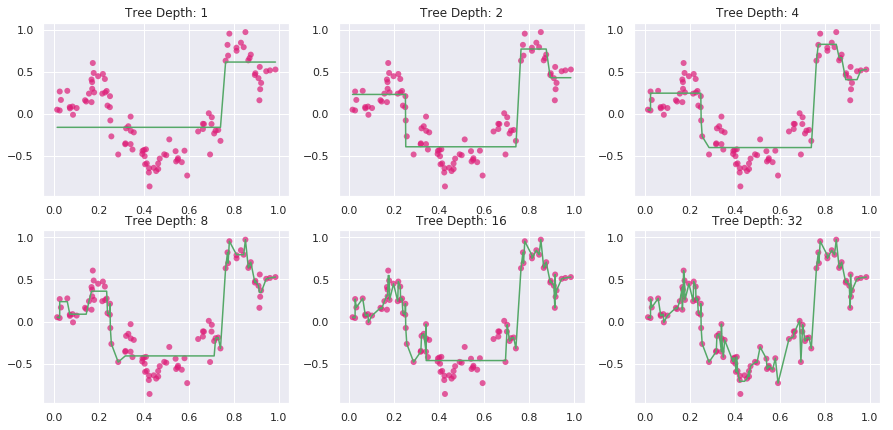

In [34]:
def plot_subplot(axis, X, y, tree_depth,
                color='#dd1c77', alpha=0.5, edgecolors='none'):
    
    def fit_predict(X_train, y_train, tree_depth, n_min_leaf=5):
        model = RegressionTree(max_depth=tree_depth, n_min_leaf=n_min_leaf)
        model.fit(X_train, y_train)
        return model.predict(X_train)

    idx = np.argsort(X)
    
    axis.scatter(X, y, color='#dd1c77', alpha=0.7, edgecolors='none')
    y = fit_predict(X.reshape(X.shape[0], 1), y, tree_depth)
    axis.plot(X[idx], y[idx],  'g-')
    axis.set_title('Tree Depth: {}'.format(tree_depth))


fig, axes = plt.subplots(2, 3, figsize=(15, 7))
tree_depths = iter([1, 2, 4, 8, 16, 32])

for i in range(2):
    for j in range(3):
        plot_subplot(axes[i][j], data_train[:, 0], data_train[:, 1], next(tree_depths))
plt.show()